In [3]:
import requests
import polyline
import gpxpy

import pandas as pd

import matplotlib.pyplot as plt
import contextily as ctx

import xml.dom.minidom
from xml.etree.ElementTree import Element, SubElement, tostring

In [4]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

def get_route(points, route_type):
    points = ';'.join(map(osrm_format, points))
    params = {
        'geometries': 'polyline6',
        'overview': 'full',
    }
    
    url = ""
    if route_type == "shortest":
        url = f"http://127.0.0.1:6000/route/v1/foot/{points}"
    elif route_type == "custom":
        url = f"http://127.0.0.1:9000/route/v1/custom/{points}"
    
    response = requests.get(url, params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    geometry = routes['routes'][0]['geometry']
    return (
        polyline.decode(geometry, 6), 
        routes['routes'][0]['distance'],
    )


def format_distance(distance):
    distance = round(distance / 1000, 1)
    return f"{distance}km"

def create_gpx(route, output_file):
    gpx = Element('gpx', {
      'creator': 'Evgeny Arbatov',
      'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
      'xsi:schemaLocation': 'http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd',
      'version': '1.1',
      'xmlns': 'http://www.topografix.com/GPX/1/1'
    })
    
    trk = SubElement(gpx, "trk")
    trkseg = SubElement(trk, "trkseg")

    for lat, lng in route:
        SubElement(trkseg, "trkpt", attrib={"lat": str(lat), "lon": str(lng)})

    with open(output_file, "w") as f:
        gpx = xml.dom.minidom.parseString(
            tostring(gpx, encoding="unicode")
        ).toprettyxml()
        
        f.write(gpx)

def parse_gpx(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat, lng = point.latitude, point.longitude
                data.append({
                  'latitude': lat, 
                  'longitude': lng,
                })

    df = pd.DataFrame(data)

    return df

def plot_gpx(shortest_df, custom_df):
    plt.figure(figsize=(15, 8))
    plt.plot(shortest_df['longitude'], shortest_df['latitude'], color='blue', label='Shortest Route')
    plt.plot(custom_df['longitude'], custom_df['latitude'], color='red', label='Custom Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()        
        
def make_route(start, stop, route_type, output_file):
    points = [start] + [stop]

    osrm_route, distance = get_route(points, route_type) 
    
    print(
        route_type,
        ":",
        format_distance(distance),
    )
    
    create_gpx(osrm_route, output_file)

shortest : 485.9km
custom : 485.9km


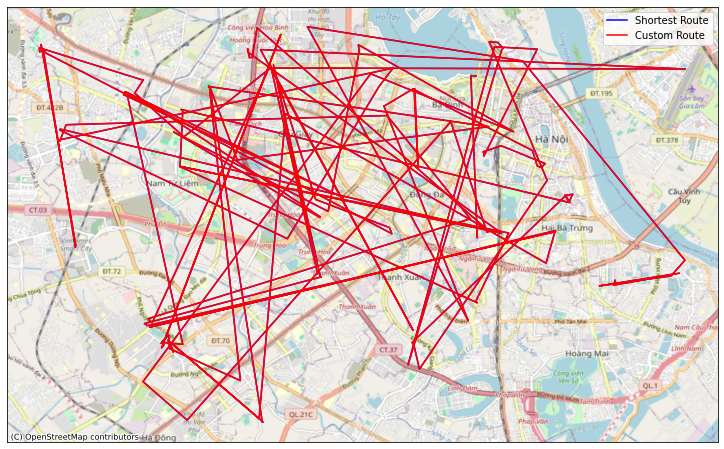

In [7]:
start = (20.993686966853396, 105.86939936393794)
stop = (21.043666864560734, 105.83550324106861)

shortest_gpx = "../routes/West Lake - Shortest Route.gpx"
custom_gpx = "../routes/West Lake - Custom.gpx"

make_route(start, stop, "shortest", shortest_gpx)
make_route(start, stop, "custom", custom_gpx)

shortest_df = parse_gpx(shortest_gpx)
custom_df = parse_gpx(custom_gpx)

plot_gpx(shortest_df, custom_df)